In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans





Load in the data (two different pools, outputs of lp_analysis.py).

-- weth/dai 500

-- weth/dai 3000


In [8]:

high_fee = pd.read_parquet('lp_analysis_output_weth_dai_events_3000.parquet')
low_fee = pd.read_parquet('lp_analysis_output_weth_dai_events_500.parquet')

high_fee['date'] = pd.to_datetime(high_fee.evt_block_time).dt.normalize()
low_fee['date'] = pd.to_datetime(low_fee.evt_block_time).dt.normalize()

end_date = min(high_fee['date'].max(),low_fee.date.max())

# clamp them so they extend over same timeframe 
high_fee = high_fee[high_fee.date <= end_date]
low_fee = low_fee[low_fee.date <= end_date]

both = pd.concat([high_fee, low_fee], ignore_index=True).sort_values('evt_block_time')

In [9]:
exclude_cols = ['amount0','amount1','event','date','evt_block_time',
                'price','pool_liquidity','volume_proxy',"('0x', 0.0, 0.0)"]


Summary looks at both pools

In [ ]:
lp_cols_low = [i for i in low_fee.columns if ('fee' not in i) & ('inventory' not in i)  & (i not in exclude_cols)]
lp_cols_high = [i for i in high_fee.columns if ('fee' not in i) & ('inventory' not in i) &  (i not in exclude_cols)]

both['dollar_swap_value'] = np.where(both.event == 'swap',
                                     abs(both['amount1']),
                                     0)

# Number of LPs
n_lps_low = len(lp_cols_low)
n_lps_high = len(lp_cols_high)

# Daily volumes
daily_vol_low = both[both.fee_rate == 500].groupby('date').dollar_swap_value.sum()
daily_vol_high = both[both.fee_rate == 3000].groupby('date').dollar_swap_value.sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

# num of LPs by fee type
ax1.bar(['Low Fee', 'High Fee'], [n_lps_low, n_lps_high], color=['tab:green', 'tab:blue'], alpha=0.7)
ax1.set_ylabel('Number of LPs')
ax1.set_title('Number of LPs by Fee Tier')
ax1.set_ylim(0, max(n_lps_low, n_lps_high)*1.2)

#  daily volume by fee tier
daily_vol_low.plot(ax=ax2, label='Low Fee', color='tab:green')
daily_vol_high.plot(ax=ax2, label='High Fee', color='tab:blue')
ax2.set_ylabel('Daily Volume ($)')
ax2.set_xlabel('Date')
ax2.set_title('Daily Swap Volume by Fee Tier')
ax2.legend()

plt.tight_layout()
plt.show()


Get lp features:
1. Total 

In [5]:

exclude_cols = ['amount0','amount1','event','date','evt_block_time','price','pool_liquidity','volume_proxy',"('0x', 0.0, 0.0)"]
all_lps =  lp_cols_low + lp_cols_high

lp_df = pd.DataFrame(index = all_lps)

import ast

for lp in all_lps:
    if lp in both.columns:
        addr, lower_tick, upper_tick = ast.literal_eval(lp)
        fee_0_str = lp + '_fee_0' # fees awarded every step
        fee_1_str = lp + '_fee_1'
        inventory_column_0 = lp + '_inventory_0'
        inventory_column_1 = lp + '_inventory_1'

        vol = np.where(
        both['event'].eq('swap'),
            both[inventory_column_0].diff().abs() * both['price'], # total volume in token0, dollarized
            0
        )
        total_vol = np.nansum(vol) 
        time_in_range = len(vol[vol>0]) # non-zero diffs mean time in range    
        dollars_fees = (both.price * both[fee_0_str]) + (both[fee_1_str]) # all fees you got, every time step
        
        raw_size = both[lp].astype(float).max()
        position_width = abs(int(upper_tick) - int(lower_tick))
        lp_df.loc[lp, 'lp_position_size'] = raw_size
        lp_df.loc[lp, 'lp_position_width'] = position_width
        lp_df.loc[lp, 'lp_size_per_tick'] = raw_size / position_width
        lp_df.loc[lp,'lp_total_fees'] = dollars_fees.sum()
        lp_df.loc[lp,'lp_total_volume'] = total_vol # a single number 
        lp_df.loc[lp,'lp_time_in_range'] = time_in_range
        lp_df.loc[lp,'lp_lifetime'] = (both[lp] > 0).sum() # L > 0 means alive
        lp_df.loc[lp,'lp_position_size'] = both[lp].astype(float).max() # size is the MAX L you ever had
        lp_df.loc[lp,'pool'] = 3000 if lp in lp_cols_high else 500
lp_df['lp_liquidity-time-in-range'] = lp_df['lp_position_size'] * lp_df['lp_time_in_range']


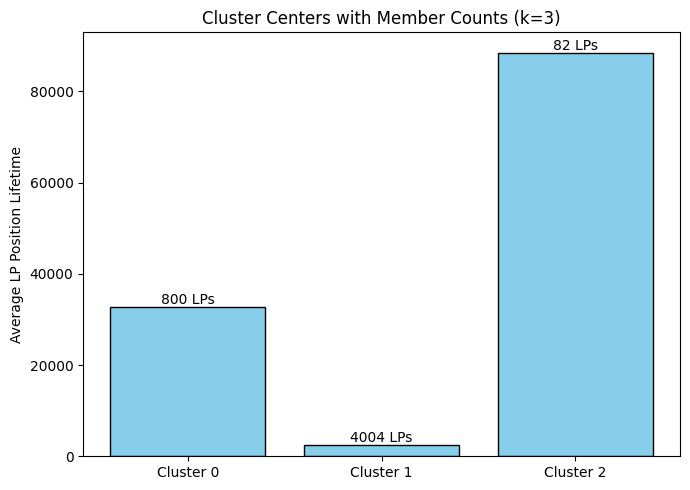

In [6]:


k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
X = lp_df[['lp_lifetime']].values
lp_df['cluster'] = kmeans.fit_predict(X)
lp_df['cluster_center'] = kmeans.cluster_centers_[lp_df['cluster']]

# Get cluster centers and counts
centers = kmeans.cluster_centers_.flatten()
counts = lp_df['cluster'].value_counts().sort_index()

x = np.arange(k)

plt.figure(figsize=(7,5))
bars = plt.bar(x, centers, color='skyblue', edgecolor='black')

# Add member count labels above each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f'{counts[i]} LPs',
             ha='center',
             va='bottom',
             fontsize=10)

plt.xticks(x, [f'Cluster {i}' for i in x])
plt.ylabel('Average LP Position Lifetime')
plt.title('Cluster Centers with Member Counts (k=3)')
plt.tight_layout()
plt.show()


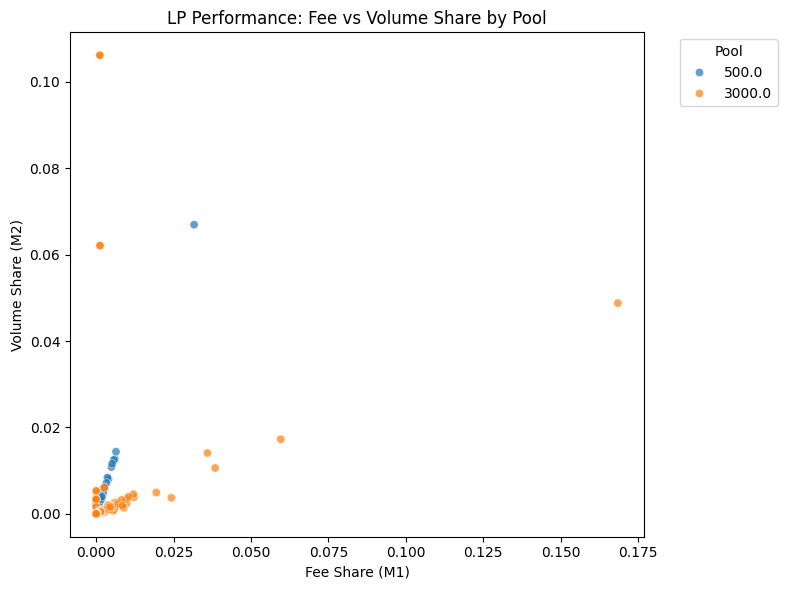

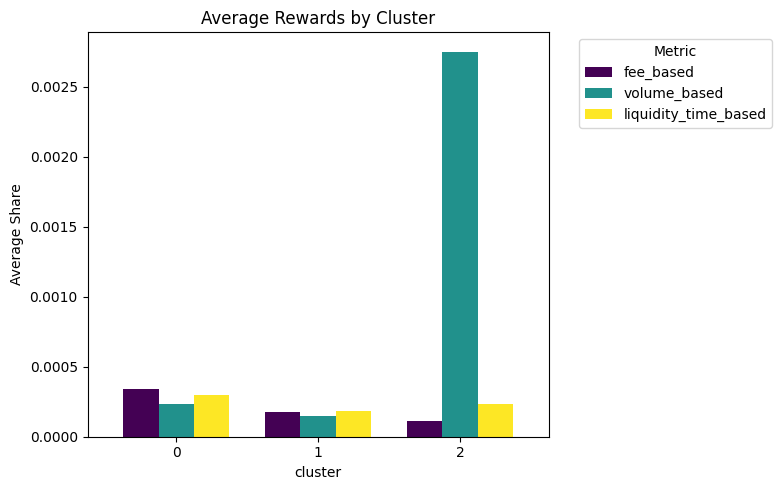

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Compute normalized metrics
lp_df['total_volume'] = lp_df.lp_total_volume.sum()
lp_df['total_liquidity_time'] = lp_df['lp_liquidity-time-in-range'].sum()
lp_df['total_fees'] = lp_df.lp_total_fees.sum()

lp_df['fee_based'] = lp_df.lp_total_fees / lp_df.total_fees
lp_df['volume_based'] = lp_df.lp_total_volume / lp_df.total_volume
lp_df['liquidity_time_based'] = lp_df['lp_liquidity-time-in-range'] / lp_df.total_liquidity_time

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=lp_df,
    x='fee_based',
    y='volume_based',
    hue='pool',
    palette='tab10',
    alpha=0.7
)
plt.xlabel('Fee Share (M1)')
plt.ylabel('Volume Share (M2)')
plt.title('LP Performance: Fee vs Volume Share by Pool')
plt.legend(title='Pool', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

cluster_summary = (
    lp_df
    .groupby('cluster')[['fee_based','volume_based','liquidity_time_based']]
    .mean()
    .sort_index()
)

plt.figure(figsize=(8,5))
cluster_summary.plot(
    kind='bar',
    figsize=(8,5),
    width=0.75,
    colormap='viridis',
    ax=plt.gca()
)
plt.ylabel('Average Share')
plt.title('Average Rewards by Cluster')
plt.xticks(rotation=0)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
